<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objective" data-toc-modified-id="Objective-1">Objective</a></span></li><li><span><a href="#About-Food-101" data-toc-modified-id="About-Food-101-2">About Food-101</a></span></li><li><span><a href="#Train-valid-split" data-toc-modified-id="Train-valid-split-3">Train-valid-split</a></span></li><li><span><a href="#Curating-A-Smaller-Dataset" data-toc-modified-id="Curating-A-Smaller-Dataset-4">Curating A Smaller Dataset</a></span></li><li><span><a href="#Load-Food-101-tiny-Dataset" data-toc-modified-id="Load-Food-101-tiny-Dataset-5">Load Food-101-tiny Dataset</a></span></li><li><span><a href="#Data-Augmentation" data-toc-modified-id="Data-Augmentation-6">Data Augmentation</a></span></li><li><span><a href="#Baseline-Resnet-34-Model" data-toc-modified-id="Baseline-Resnet-34-Model-7">Baseline Resnet-34 Model</a></span><ul class="toc-item"><li><span><a href="#Finding-a-Good-Learning-Rate" data-toc-modified-id="Finding-a-Good-Learning-Rate-7.1">Finding a Good Learning Rate</a></span></li><li><span><a href="#Training-the-Head-Only" data-toc-modified-id="Training-the-Head-Only-7.2">Training the Head Only</a></span></li><li><span><a href="#Training-the-Entire-Network" data-toc-modified-id="Training-the-Entire-Network-7.3">Training the Entire Network</a></span></li><li><span><a href="#Test-Time-Augmentation" data-toc-modified-id="Test-Time-Augmentation-7.4">Test Time Augmentation</a></span></li><li><span><a href="#Post-mortem" data-toc-modified-id="Post-mortem-7.5">Post-mortem</a></span></li></ul></li><li><span><a href="#First-Crack-at-a-Better-Model" data-toc-modified-id="First-Crack-at-a-Better-Model-8">First Crack at a Better Model</a></span><ul class="toc-item"><li><span><a href="#Progressive-Resizing" data-toc-modified-id="Progressive-Resizing-8.1">Progressive Resizing</a></span></li><li><span><a href="#Label-Smoothing" data-toc-modified-id="Label-Smoothing-8.2">Label Smoothing</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import torch

from pathlib import Path
from fastai2.vision.all import *
from fastai2.vision.widgets import *

In [2]:
# Set seed for reproducibility
seed = 9
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
# Silence warnings for readability
import warnings
warnings.filterwarnings("ignore")

---------

# Objective

The goal of this notebook is to train an image classifier on a small subset of the [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101) using the `fastai2` library. Training on a subset will help us iterate and experiment more quickly. Once we're sure we have the key pieces in place, we'll train on the full dataset in a separate notebook.

--------

# About Food-101

The [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) consists of 101 classes of food, with $750$ training images and $250$ validation images for each class, for a total of $75,750$ training images and $25,250$ validation images. Classes include foods like `apple pie, bibimbap, crab cakes, gyoza, nachos, and pho`.

All images have been rescaled to have a maximum side length of $512$ pixels and training images have been deliberately left uncleaned (mostly in the form of intense colours and occassionally incorrect labels, according to the authors of the [original paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)). Examining a few images from a handful of classes, we find that $512$ x $384$ (or the transpose) is a common image size. We also find that a non-trivial amount of labels are shockingly incorrect. One of the images labeled "french toast", for example, is an image of an omelette.

-----

# Train-valid-split

We've split the `Food-101` dataset beforehand into Imagenet-style `train/` and `valid/` folders following the `train.txt` and `test.txt` files provided in the dataset's `meta/` directory. This makes loading the data easier as with fastai.

--------

# Curating A Smaller Dataset

To help speed development and prototyping, we'll work initially with a subset of the `Food-101` dataset. We'll select the following ten categories of food to work with: `apple pie, bibimbap, cannoli, edamame, falafel, french toast, ice cream, ramen, sushi, and tiramisu`. We chose a diverse group of categories to make things easier for us, at least in the beginning (admittedly, we also chose some of our favourite foods 😅). 

--------

# Load Food-101-tiny Dataset

Let's load and prep our curated dataset for modeling.

In [3]:
# Prep DataBlock with item & batch transforms
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                  get_items=get_image_files,
                  get_y=parent_label,
                  item_tfms=Resize(512),
                  batch_tfms=aug_transforms(size=256, min_scale=0.75))

# Load data
path = Path("../data/food-101-tiny")
dls = dblock.dataloaders(path, bs=128)

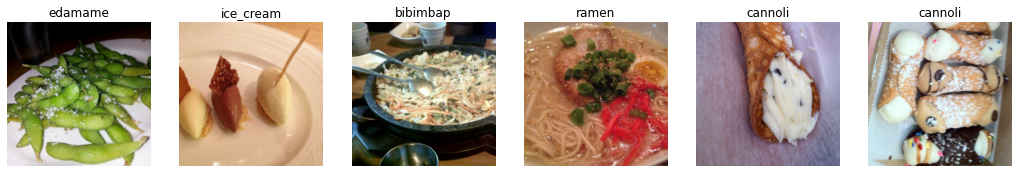

In [9]:
# Check data; yum! looks good!
dls.show_batch(nrows=1, ncols=6)

# Data Augmentation

When we initalised our `DataBlock` above, we had to specify what types of transforms we wanted to use to augument our data. We used the standard transforms specified in `aug_transforms`. Let's take a closer look at these transforms before we begin training. 

---------

# Baseline Resnet-34 Model

Let's start with `Resnet-34` and the default fastai `cnn_learner` parameters as our baseline model. We will

* Start by finding a good initial learning rate for training the head of the model
* Train for a few epochs with all layers frozen except for the head
* Unfreeze all layers and find a good learning rate range to use for all layers
* Train the entire unfrozen network with discriminative learning rates

We'll use `Top-1` and `Top-5` accuracy as our validation metrics throughout. 

Note that `cnn_learner` automatically normalizes its data using the stats of the pre-trained model (which will be `ImageNet` stats in our case).

## Finding a Good Learning Rate

Let's start by finding a good base learning rate.

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.0063095735386013985)

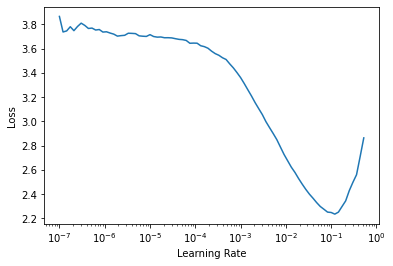

In [10]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.lr_find()

Looks like the steepest slope is `6e-3`. Let's choose that as our base learning rate and train the head  for a few epochs, keeping the other layers frozen.

## Training the Head Only

Now let's train the head of the network using the learning rate we found above.

In [11]:
learn.fit_one_cycle(4, 6e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.129801,0.701501,0.798000,0.981500,01:40
1,0.678408,0.478483,0.860500,0.988000,01:39
2,0.468246,0.400005,0.883000,0.990500,01:39
3,0.329071,0.366164,0.892000,0.989500,01:39


## Training the Entire Network

Now that we've trained the head for a few epochs, we're ready to unfreeze and train the entire network. But before we train we need to find a good range of learning rates to use. Note that the learning rate plot will be different to the one above, since our model has been trained for a bit.

SuggestedLRs(lr_min=1.9054606673307718e-05, lr_steep=4.786300905834651e-06)

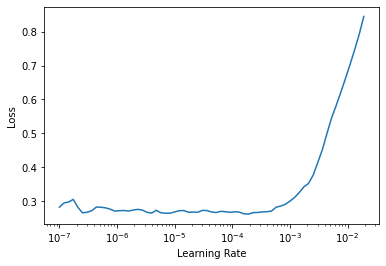

In [12]:
learn.unfreeze()
learn.lr_find()

We're looking for a range well before the loss sharply increases. Looks like `[1e-5, 3e-4]` will do. Now we're ready to train the entire unfrozen network.

In [13]:
learn.fit_one_cycle(6, lr_max=slice(1e-5, 3e-4))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.254095,0.350147,0.896500,0.991500,02:06
1,0.241770,0.352708,0.899000,0.992000,02:07
2,0.184886,0.323513,0.903000,0.992000,02:07
3,0.132668,0.315959,0.906500,0.990500,02:07
4,0.100097,0.312669,0.912000,0.991500,02:07
5,0.086226,0.314342,0.912000,0.992000,02:07


## Test Time Augmentation

The last thing we can do to squeeze out a bit of performance is use test time augmentation. We'll use fastai's default `tta()` method, which averages a model's prediction with the predictions from 4 augmented images.

In [14]:
preds, targets = learn.tta()
top_1 = accuracy(preds, targets).item()
top_5 = top_k_accuracy(preds, targets, k=5).item()
print(f"Top-1 Accuracy: {top_1: .4f} | Top-5 Accuracy {top_5: .4f}")

Top-1 Accuracy:  0.9170 | Top-5 Accuracy  0.9925


## Post-mortem

Let's take a closer look at which classes our model had a hard time with. Finally, we'll flip through the images of the classes that our model struggled most with and see if there are any with incorrect labels.

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=5)

[('french_toast', 'apple_pie', 13),
 ('apple_pie', 'french_toast', 11),
 ('ice_cream', 'tiramisu', 10),
 ('apple_pie', 'tiramisu', 8),
 ('cannoli', 'tiramisu', 8),
 ('ice_cream', 'apple_pie', 7),
 ('sushi', 'apple_pie', 7),
 ('tiramisu', 'ice_cream', 7),
 ('apple_pie', 'ice_cream', 6),
 ('cannoli', 'apple_pie', 6),
 ('sushi', 'french_toast', 6),
 ('apple_pie', 'cannoli', 5),
 ('falafel', 'apple_pie', 5),
 ('ramen', 'bibimbap', 5),
 ('tiramisu', 'apple_pie', 5)]

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [30]:
# Delete selected images
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

------------

# First Crack at a Better Model

Now that we have a solid baseline model, it's time to experiment and see if we can't do a little better! We'll experiment with

* Progressive resizing
* Label smoothing
* Mixup

## Progressive Resizing 

Progressive resizing is the process of gradually using larger and larger images as you train. The key insight behind progressive resizing is the idea that the types of features CNNs learn aren't specific to the size of the images used. By initially training on smaller images, epochs complete much faster. Finishing training on larger images makes the final accuracy much higher. Progresive resizing also functions as another form of data augmentation and so should help a model generalize.

To implement progressive resizing, we'll define a function that returns a set of dataloaders of images of a specified size.

In [4]:
def get_dls(path, bs, size):
    """Return a set of train and valid dataloaders with images of a given size."""
    dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                  get_items=get_image_files,
                  get_y=parent_label,
                  item_tfms=Resize(512),
                  batch_tfms=aug_transforms(size=size, min_scale=0.75))
    return dblock.dataloaders(path, bs=bs)

In [8]:
# First train on images of size 128
dls = get_dls(path, bs=128, size=128)
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(4, 6e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.575609,1.118281,0.700350,00:56
1,0.975794,0.655665,0.778889,00:53
2,0.702851,0.579768,0.804902,00:55
3,0.554177,0.547024,0.817909,00:54


In [9]:
# Bump image size to 256
learn.dls = get_dls(path, bs=128, size=256)
learn.fine_tune(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.566854,0.371210,0.876438,01:45


epoch,train_loss,valid_loss,accuracy,time
0,0.426158,0.314380,0.896948,02:08
1,0.334145,0.279353,0.904452,02:07
2,0.246533,0.271428,0.912456,02:06
3,0.188233,0.262409,0.912456,02:07


In [12]:
# Bump image size to 512 (max image size)
learn.dls = get_dls(path, bs=32, size=512)
learn.fine_tune(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.482167,0.367262,0.883942,05:18


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0f873197a0>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0f873197a0>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/site-p

epoch,train_loss,valid_loss,accuracy,time
0,0.384746,0.300012,0.901951,07:04
1,0.310334,0.303281,0.905953,07:02
2,0.187844,0.242630,0.920960,07:02
3,0.144020,0.225177,0.929965,07:02


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0f873197a0>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0f873197a0>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/site-p

    w.join()
  File "/home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0f873197a0>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ubuntu/anaconda3/envs/fastai2/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0f873197a0>
Traceback (mos

## Label Smoothing